In [1]:
N_NEIGHBORS = 11

# CONSTANTES CONTENT BASED

# CAMINHOS

PATH_TO_FULL_CB_FILE = "../../preprocessed-data/CB/data_cb.pkl"

PATH_TO_MOVIES_CB_FILE = "../../preprocessed-data/CB/movies_cb.pkl"

PATH_TO_RATINGS_CB_FILE = "../../preprocessed-data/CB/ratings_cb.pkl"

PATH_TO_RATINGS_INFOS_CB_FILE = "../../preprocessed-data/CB/ratings_info_cb.pkl"

PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE = "../../preprocessed-data/CB/tag_relevance_grouped_cb.pkl"

PATH_TO_TAG_RELEVANCE_CB_FILE = "../../preprocessed-data/CB/tag_relevance_cb.pkl"

PATH_TO_TAGS_PROCESSED_CB_FILE = "../../preprocessed-data/CB/tags_processed_cb.pkl"

# DataFrames Names

# data_cb = arquivo completo 
# movies_cb = arquivos de filmes
# ratings_cb = arquivos de ratings
# ratings_infos_cb = arquivos de informações sobre os ratings
# tag_relevance_grouped_cb = relevancia de tags após o agrupamento
# tag_relevance_cb = relevancia de tags original
# tags_processed_cb = tags todas juntas em uma coluna e processadas pelo nltk

In [2]:
# Importando bibliotecas necessárias
import pandas as pd
pd.set_option("display.max_rows", 25)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import sys

# Importando garbage collector
import gc

# Importando bibliotecas para o sistema de recomendação
import scipy.sparse as sparse # Matriz esparsa (csr_matrix)

# Importando sklearn
import sklearn
from sklearn.neighbors import NearestNeighbors

# Importando Regular Expression operations
import re

# 1 - Preparação dos dados para Content Based - tags


In [3]:
def load_cb_files(full=True, movies=False, ratings=False, ratings_infos=False ,relevance_grouped=False, relevance=False, tags_processed=False):
    data_cb = None
    movies_cb = None 
    ratings_cb = None
    ratings_infos_cb = None
    tag_relevance_grouped_cb = None
    tag_relevance_cb = None
    tags_processed_cb = None
    
    # Caso se queira carregar o completo
    if(full):
        data_cb = pd.read_pickle(PATH_TO_FULL_CB_FILE)
        print("Arquivo completo: Carregado com sucesso!")
    else:
        print("Arquivo completo: Não foi carregado, verifique se era o que desejava.")
    
    # Caso queira-se carregar o arquivo de filmes
    if(movies):
        movies_cb = pd.read_pickle(PATH_TO_MOVIES_CB_FILE)
        print("Arquivo movies: Carregado com sucesso!")
    else:
        print("Arquivo movies: Não foi carregado, verifique se era o que desejava.")
        
    if(ratings):
        ratings_cb = pd.read_pickle(PATH_TO_RATINGS_CB_FILE)
        print("Arquivo ratings: Carregado com sucesso!")
    else:
        print("Arquivo ratings: Não foi carregado, verifique se era o que desejava.")
    
    if(ratings_infos):
        ratings_infos_cb = pd.read_pickle(PATH_TO_RATINGS_INFOS_CB_FILE)
        print("Arquivo ratings infos: Carregado com sucesso!")
    else:
        print("Arquivo ratings infos: Não foi carregado, verifique se era o que desejava.")
        
    if(relevance_grouped):
        tag_relevance_grouped_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE)
        print("Arquivo relevance grouped: Carregado com sucesso!")
    else:
        print("Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.")
    
    if(relevance):
        tag_relevance_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_CB_FILE)
        print("Arquivo relevance: Carregado com sucesso!")
    else:
        print("Arquivo relevance: Não foi carregado, verifique se era o que desejava.")
        
    if(tags_processed):
        tags_processed_cb = pd.read_pickle(PATH_TO_TAGS_PROCESSED_CB_FILE)
        print("Arquivo tags processed: Carregado com sucesso!")
    else:
        print("Arquivo tags processed: Não foi carregado, verifique se era o que desejava.")
        
        
    return data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb
    

In [4]:
data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb = load_cb_files(full=True, movies=True, ratings_infos=True, tags_processed=True)

Arquivo completo: Carregado com sucesso!
Arquivo movies: Carregado com sucesso!
Arquivo ratings: Não foi carregado, verifique se era o que desejava.
Arquivo ratings infos: Carregado com sucesso!
Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.
Arquivo relevance: Não foi carregado, verifique se era o que desejava.
Arquivo tags processed: Carregado com sucesso!


In [5]:
movies_cb.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [6]:
tags_processed_cb.head()

,movieId,tags,tags_processed
0,1,owned imdb top 250 pixar pixar time travel chi...,imdb top pixar pixar time travel child comedy ...
1,2,robin williams time travel fantasy based on ch...,robin williams time travel fantasy base child ...
2,3,funny best friend duringcreditsstinger fishing...,funny best friend duringcreditsstinger fish ol...
3,4,based on novel or book chick flick divorce int...,base novel book chick flick divorce interracia...
4,5,aging baby confidence contraception daughter g...,age baby confidence contraception daughter gyn...


## 1.1 Transformando tags em estrutura de listas

In [7]:
# colocando as tags processadas em listas
tags_list_df = tags_processed_cb.copy()

tags_list_df['tags_processed'] = tags_list_df['tags_processed'].str.split(' ')

tags_list_df.drop("tags", inplace=True, axis=1)

tags_list_df.head()

,movieId,tags_processed
0,1,"[imdb, top, pixar, pixar, time, travel, child,..."
1,2,"[robin, williams, time, travel, fantasy, base,..."
2,3,"[funny, best, friend, duringcreditsstinger, fi..."
3,4,"[base, novel, book, chick, flick, divorce, int..."
4,5,"[age, baby, confidence, contraception, daughte..."


In [8]:
#Carregando lista de tags unicas
tags_list = pd.read_pickle('../../preprocessed-data/CB/movies_tags_matrix/processed_tags_list.pkl');
#print(tags_list)

## 1.2 Criando listas auxiliares para reconhecimento de linhas e colunas. Recuperando dimensoes da matriz. Para criação manual.

In [9]:
# pegando lista de moviesID
moviesId_list = tags_list_df["movieId"].tolist()

# recuperando dimensoes da matriz
number_of_movies_with_tags = len(moviesId_list) # num linhas
number_of_tags = len(tags_list) # num colunas

In [10]:
# criando uma matriz temporaria preenchida nos locais corretos
temp = np.zeros((number_of_movies_with_tags, number_of_tags))

In [11]:
#Carregando coordenadas da matriz a serem preenchidas
coordinates_to_fill = pd.read_pickle('../../preprocessed-data/CB/movies_tags_matrix/coordinates_to_fill.pkl')

In [12]:
# preenchendo essa matriz nos locais corretos
for coordinate in coordinates_to_fill:
    temp[coordinate[0]][coordinate[1]] = 1

In [13]:
# criando a matriz final - esparsa
movies_tags_matrix = sparse.csr_matrix(temp, dtype=int)

movies_tags_matrix

<45251x32443 sparse matrix of type '<class 'numpy.intc'>'
	with 608415 stored elements in Compressed Sparse Row format>

## 1.3 Criando modelo KNN

In [14]:
# Criando o modelo knn utilizando as tags
knn_tags_processed_cb = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='auto', metric='cosine') # temos que mexer nos parâmetros posteriormente

knn_tags_processed_cb.fit(movies_tags_matrix)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [15]:
# criando função que gera recomendações basedo em um filme - utilizando um modelo KNN - baseando-se nas tags processadas
def get_recommendations_tags_processed_cb(movie_name, model): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = movies_cb.loc[movies_cb["title"] == movie_name]["movieId"].values[0]
    
    index = moviesId_list.index(movieId)
    
    distances, suggestions = model.kneighbors(movies_tags_matrix.getrow(index).todense().tolist(), n_neighbors=N_NEIGHBORS)
    
    suggestionsIds_list = [moviesId_list[index] for index in suggestions.flatten()]
    
    for i in range(0, len(distances.flatten())):
        if(i == 0):
            print('Recomendações para {0}: \n'.format(movie_name))
        else:
            print('{0}: {1}, com distância de: {2}'.format(i, movies_cb.loc[movies_cb["movieId"] == suggestionsIds_list[i]]["title"].values[0], distances.flatten()[i]))
    
    return distances, suggestions

In [16]:
def search_movies(search_word, data):
    return data[data.title.str.contains(search_word, flags=re.IGNORECASE)]

In [17]:
search_movies("Schindler", movies_cb)

,movieId,title,genres,year
522,527,Schindler's List,"[Drama, War]",1993


In [18]:
movieName = "Teenage Mutant Ninja Turtles"
a, b = get_recommendations_tags_processed_cb(movieName, knn_tags_processed_cb)

Recomendações para Teenage Mutant Ninja Turtles: 

1: Teenage Mutant Ninja Turtles II: The Secret of the Ooze, com distância de: 0.470990788106051
2: Teenage Mutant Ninja Turtles III, com distância de: 0.4978866767041308
3: TMNT (Teenage Mutant Ninja Turtles), com distância de: 0.589662497848854
4: Top Cat The Movie, com distância de: 0.722945742076234
5: Clifford's Really Big Movie, com distância de: 0.7268208176459234
6: A Man Called Hero, com distância de: 0.7268208176459234
7: Adventures of Rocky and Bullwinkle, The, com distância de: 0.7268208176459234
8: Dudley Do-Right, com distância de: 0.728930340971321
9: Inspector Gadget, com distância de: 0.7295664067498104
10: It's a Very Merry Muppet Christmas Movie, com distância de: 0.7295664067498104


## 1.4 Utilizando umap para exibir os agrupamentos

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

import umap
import umap.plot

In [20]:
#caso queira restar a variavel

#%reset_selective trans
#%reset

In [21]:
# criando função que gera recomendações basedo em um filme - utilizando um modelo KNN - baseando-se nas tags processadas
def get_recommendations_tags_processed_cb2(movie_name, model, data): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = data.loc[data["title"] == movie_name]["movieId"].values[0]
    
    index = moviesId_list.index(movieId)
    
    
    distances = model[1][index] 
    suggestions = model[0][index]
    suggestionsIds_list = [moviesId_list[index] for index in suggestions.flatten()]
   #print(suggestionsIds_list)
    
    for i in range(0, len(distances.flatten())):
        if(i == 0):
            print('Recomendações para {0} (ID: {1}): \n'.format(movie_name, movieId))
        else:
            print('{0}: {1} (ID: {2}), com distância de: {3}'.format(i, data.loc[data["movieId"] == suggestionsIds_list[i]]["title"].values[0], data.loc[data.movieId == suggestionsIds_list[i]]["movieId"].values[0],distances.flatten()[i]))
    
    return distances, suggestions

In [22]:
%%time
from umap.umap_ import nearest_neighbors
knn_tags_processed_cb2 = nearest_neighbors(X=movies_tags_matrix,n_neighbors=N_NEIGHBORS, random_state = 64, metric='cosine', metric_kwds=None, angular=False)

Wall time: 45.8 s


In [23]:
%%time
trans = umap.UMAP(n_neighbors=N_NEIGHBORS, precomputed_knn=knn_tags_processed_cb2, random_state=64, verbose=True).fit(movies_tags_matrix)

UMAP(n_neighbors=11, precomputed_knn=(array([[    0, 2858, 4537, ..., 1081, 10348, 3986],
       [    1, 9964, 42420, ..., 32138, 345, 16762],
       [    2, 3172, 44152, ..., 22985, 24733, 13218],
       ...,
       [45248, 42951, 29524, ..., 36090, 30162, 39834],
       [45249, 42951, 29524, ..., 30162, 42093, 40784],
       [45250, 45235, 42728, ..., 12517, 16341, 9162]], dtype=int64), array([[1.19209271e-07, 5.39437031e-01, 6.49781565e-01, ...,
        7.33951265e-01, 7.39543330e-01, 7.40336969e-01],
       [0.00000000e+00, 7.23090684e-01, 7.37387132e-01, ...,
        7.72570576e-01, 7.72570576e-01, 7.72570576e-01],
       [1.19209271e-07, 5.88235344e-01, 7.69910524e-01, ...,
        8.01970486e-01, 8.28501418e-01, 8.28501418e-01],
       ...,
       [0.00000000e+00, 4.99999979e-01, 5.91751691e-01, ...,
        6.46446609e-01, 6.46446609e-01, 6.46446609e-01],
       [1.19209271e-07, 4.22649752e-01, 5.28595514e-01, ...,
        5.91751724e-01, 5.91751724e-01, 5.91751724e-01],
      

Epochs completed:   0%|            0/200 [00:00]

Mon Feb 21 14:43:01 2022 Finished embedding
Wall time: 38.9 s


In [24]:
# %%time
# trans = umap.UMAP(n_neighbors=N_NEIGHBORS, metric='euclidean', random_state=64,verbose=True).fit(sparse_matrix_cb)

In [25]:
movieName = "Schindler's List"
a2, b2, = get_recommendations_tags_processed_cb2(movieName, knn_tags_processed_cb2, movies_cb)

Recomendações para Schindler's List (ID: 527): 

1: Pianist, The (ID: 5995), com distância de: 0.6657484054917202
2: Saving Private Ryan (ID: 2028), com distância de: 0.6917792939722189
3: Braveheart (ID: 110), com distância de: 0.7077074733107847
4: One Flew Over the Cuckoo's Nest (ID: 1193), com distância de: 0.7119670495337562
5: Godfather, The (ID: 858), com distância de: 0.7128167167708409
6: Lawrence of Arabia (ID: 1204), com distância de: 0.7145900077219679
7: Life Is Beautiful (La Vita è bella) (ID: 2324), com distância de: 0.7151515156432878
8: Forrest Gump (ID: 356), com distância de: 0.7177081094081719
9: City of God (Cidade de Deus) (ID: 6016), com distância de: 0.7230769324856966
10: Amadeus (ID: 1225), com distância de: 0.7315120741794519


In [26]:
def plotKNN(movieName, data, a, b, zoom):
    # pegando a lista de recomendações
    movieId = data.loc[data["title"] == movieName]["movieId"].values[0]
    recommendations_ids = b.flatten()
    real_ids = []
    averageRating = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['average rating']
    numRatings = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['rating count']
    
    
    
    #transformando a lista de recomendações pelos ids reais dos filmes de acordo com a lista de apoio
    real_ids = [moviesId_list[index] for index in recommendations_ids]
    
#     for i in recommendations_ids:
#         real_ids.append([list(recommendations_ids).index(i)]) = moviesId_list[i]
#         print(recommendations_ids)
    
    #plotando grafico dos generos primarios
    #umap.plot.points(trans, labels=labels, theme='darkblue', color_key_cmap='Paired')   
    
    
    fig, ax = plt.subplots(figsize=(14, 10))

    # AREA DO GRAFICO BASE
    #mostrando os valores normais
    ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=5, facecolors='black', cmap='Spectral', alpha=0.15, linewidths=1)
    #mostrando filme pedido pelo usuario
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=5, c='blue', cmap='Spectral', alpha=0.7)
    #mostrando filmes recomendados
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=0.7)
    #nota_media = '%.4f' % averageRating.values[0]
    ax.set(title='KNN' + ' - Recomendações para ' + movieName + ' - Numero de Ratings: ' + str(numRatings.values[0]) +
           ' - Numero de Tags: ' +  str(len(list(tags_list_df[tags_list_df.movieId == movieId].tags_processed)[0])))
    
    ax.set_xlim(-10, 25)
    ax.set_ylim(-2, 20)
    
    # verificando se os pontos gerados são nan, se for, é impossivel exibir essas recomendações graficamente
    if(np.isnan(trans.embedding_[:, 0][recommendations_ids]).all() and np.isnan(trans.embedding_[:, 1][recommendations_ids]).all()):
        print("Não foi possivel gerar o gráfico para as recomendações de {0}, por favor tente outro filme.\n" .format(movieName))
        return
    
    # mostrando legenda
   

    colors_list =  ['blue', 'red', 'green', 'yellow', 'magenta', 'brown', 'orange', 'black', 'indigo', 'chocolate', 'turquoise']
    legend_list = []
    # filme
    filme_pesquisado = mlines.Line2D([],[], linestyle='None', color='blue', marker="*", markersize=15,
                                     label=list(movies_cb[movies_cb.movieId == real_ids[0]].title)[0])
    legend_list.append(filme_pesquisado)
    
    for i in range(1, 11):
        filme_recomendado = mlines.Line2D([],[], linestyle='None', color=colors_list[i], marker=".", markersize=13,
                                       label=list(movies_cb[movies_cb.movieId == real_ids[i]].title)[0])
    
        legend_list.append(filme_recomendado)
        
    ax.legend(handles=legend_list)
    
    # AREA DO ZOOM
    axins = zoomed_inset_axes(ax, zoom, loc=3) # zoom = 8
    #axins.set(title='Recomendações para ' + movieName)
    #mostrando os valores normais
    axins.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=3, facecolors='grey', cmap='Spectral', alpha=0.6, linewidths=0.7)
    #mostrando filme pedido pelo usuario
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=20, c='blue', cmap='Spectral', alpha=1)
    #mostrando filmes recomendados
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=1)
    
    #mostrando os filmes 1 ao 10
    for i in range(1, 11):
        axins.scatter(trans.embedding_[:, 0][recommendations_ids[i]], trans.embedding_[:, 1][recommendations_ids[i]], s=5, c=colors_list[i], cmap='Spectral', alpha=1)
        
    #setando os limites do plot do zoom - min e max de cada axis + um offset
    offset = 0.2

    axins.set_xlim(np.nanmin(trans.embedding_[:, 0][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 0][recommendations_ids]) + offset)
    axins.set_ylim(np.nanmin(trans.embedding_[:, 1][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 1][recommendations_ids]) + offset)


    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)
    #
    ## draw a bbox of the region of the inset axes in the parent axes and
    ## connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")

    plt.draw()
    plt.show()


In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))

Recomendações para Schindler's List (ID: 527): 

1: Pianist, The (ID: 5995), com distância de: 0.6657484054917202
2: Saving Private Ryan (ID: 2028), com distância de: 0.6917792939722189
3: Braveheart (ID: 110), com distância de: 0.7077074733107847
4: One Flew Over the Cuckoo's Nest (ID: 1193), com distância de: 0.7119670495337562
5: Godfather, The (ID: 858), com distância de: 0.7128167167708409
6: Lawrence of Arabia (ID: 1204), com distância de: 0.7145900077219679
7: Life Is Beautiful (La Vita è bella) (ID: 2324), com distância de: 0.7151515156432878
8: Forrest Gump (ID: 356), com distância de: 0.7177081094081719
9: City of God (Cidade de Deus) (ID: 6016), com distância de: 0.7230769324856966
10: Amadeus (ID: 1225), com distância de: 0.7315120741794519


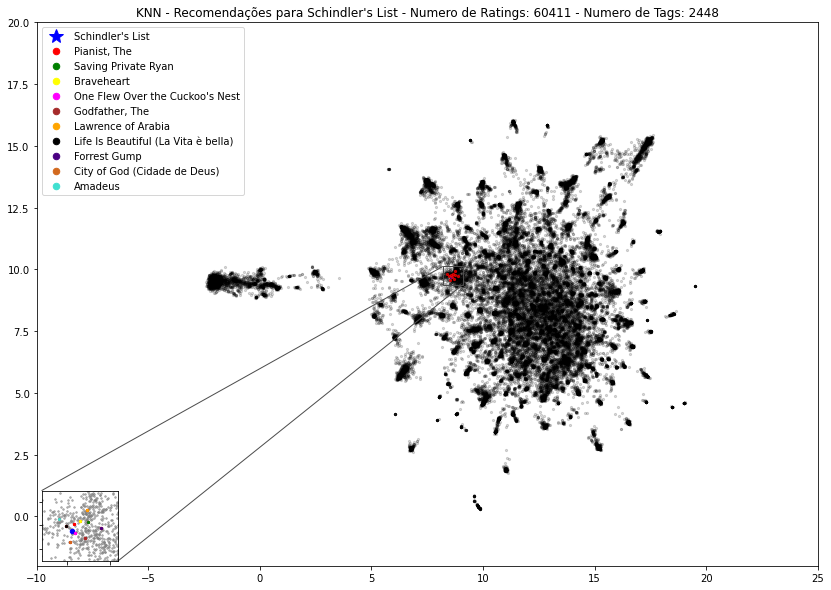

In [28]:
def callRecomendationsAndGraph(movieName, zoom):
    
    #a, b = get_recommendations_genres_cb(movieName, knn_genres_cb, movies_cb)
    a2, b2 = get_recommendations_tags_processed_cb2(movieName, knn_tags_processed_cb2, movies_cb)
    
    plotKNN(movieName, movies_cb, a2, b2, zoom)

callRecomendationsAndGraph(movieName, 3.85)

In [29]:
from collections import Counter

tags_labels = []
for i in list(movies_cb_tags.index):
    c = Counter(list(movies_cb_tags[movies_cb_tags.index == i]['tags_processed'])[0])
    c.most_common(1)
    tags_labels.append(c.most_common(1)[0][0])
    #print ("",c.most_common(1)[0][0])

NameError: name 'movies_cb_tags' is not defined

In [ ]:
#umap.plot.points(trans, labels=year_labels, theme='darkblue', color_key_cmap='Paired')   

In [ ]:
movies_cb_tags = movies_cb.merge(tags_list_df, on='movieId')

movies_cb_tags_hover = movies_cb_tags.copy()

movies_cb_tags_hover['principal_tag'] = tags_labels

movies_cb_tags_hover.pop("tags_processed")

In [ ]:
umap.plot.output_notebook()
p = umap.plot.interactive(trans, labels=tags_labels, hover_data=movies_cb_tags_hover, point_size=2)
umap.plot.show(p)

In [ ]:
print(b2)


In [ ]:
movies_cb[movies_cb.movieId == 148624]

In [ ]:
print(len(tags_list))
print(tags_list[0])


In [ ]:
tags_list_df

In [ ]:
moviesId_list.index(3255)

In [30]:
print(number_of_tags)

32443
